In [ ]:
%pip install pandas 
 

# Loading Library

In [1]:
# 기본라이브러리 import
#from google.colab import drive
#import os, json, pickle
#import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 파이토치 라이브러리 import
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

#Keras Import
import tensorflow as tf
from tensorflow.keras import layers
from datetime import timedelta, datetime

# 데이터 정규화
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action='ignore')

import ipaddress

# 구글 드라이브 mount
#drive.mount('/content/gdrive')

# 데이터 파일 위치
#C:\Users\mariu\내 드라이브\Colab Notebooks\Network
colab_path = '/home/marius1406/'
colab_write_path = "/home/marius1406/"

2023-10-12 01:31:30.954518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
colab_path = "/home/marius1406/"
df = pd.read_csv(colab_path+"NF-UQ-NIDS-total.csv",index_col=False, nrows=3000000)
#df = pd.read_csv(colab_path+"NF-UQ-NIDS-total.csv",index_col=False)

In [3]:
# 확장판에서 사용
#cols = df.columns.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'DNS_QUERY_ID','Label','Attack','Dataset'])  #명목형변수, 레이블 변수 제외
#cols = df.columns.drop(['IPV4_SRC_ADDR_1','IPV4_SRC_ADDR_2','Label','Attack','Dataset', 'Label_1','Attack_1','Dataset_1', 'Label_2','Attack_2','Dataset_2'])  #명목형변수, 레이블 변수 제외
cols = df.columns.drop(['Label','Attack'])  #명목형변수, 레이블 변수 제외#cols = df.columns.drop(['Attack','Dataset'])  #명목형변수, 레이블 변수 제외
X = df[cols]
dummies = pd.get_dummies(df['Attack']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
Y = dummies.values

#==================
dummiesLabel = pd.get_dummies(df['Label']) # Classification
y_1_label = df['Label'].values
y_label = dummiesLabel.values

#import pandas as pd
#import numpy as np

def extend_sparse(val):
    if val in ['Analysis', 'Exploits', 'Fuzzers', 'Shellcode', 'Theft', 'Worms', 'mitm']: return 1
    return 0

y_1_attack = pd.DataFrame(df['Attack'])

is_sparse = y_1_attack.applymap(extend_sparse)
y_1_enforce = is_sparse.values
y_enforce = pd.get_dummies(is_sparse['Attack']) # Classification

#=======================

def max_8G(val):
    if (val > 1.0e+9): return 1.0e+9
    return val

#cols =['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT']
cols =['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
'DST_TO_SRC_SECOND_BYTES_1', 'SRC_TO_DST_SECOND_BYTES_1', 'SRC_TO_DST_AVG_THROUGHPUT_1', 'DST_TO_SRC_AVG_THROUGHPUT_1',
'DST_TO_SRC_SECOND_BYTES_2', 'SRC_TO_DST_SECOND_BYTES_2', 'SRC_TO_DST_AVG_THROUGHPUT_2', 'DST_TO_SRC_AVG_THROUGHPUT_2'] 

X[cols] = X[cols].applymap(max_8G)

In [4]:
for col in X.columns:
    print(col , X[col].max())

IPV4_SRC_ADDR 4294101346
L4_SRC_PORT 65535
IPV4_DST_ADDR 4294967295
L4_DST_PORT 65535
PROTOCOL 255
L7_PROTO 248.0
IN_BYTES 74055365
IN_PKTS 192610
OUT_BYTES 155498038
OUT_PKTS 104565
TCP_FLAGS 223
CLIENT_TCP_FLAGS 223
SERVER_TCP_FLAGS 223
FLOW_DURATION_MILLISECONDS 4294967
DURATION_IN 106636
DURATION_OUT 38547
MIN_TTL 255
MAX_TTL 255
LONGEST_FLOW_PKT 65212
SHORTEST_FLOW_PKT 1506
MIN_IP_PKT_LEN 547
MAX_IP_PKT_LEN 65212
SRC_TO_DST_SECOND_BYTES 1000000000.0
DST_TO_SRC_SECOND_BYTES 1000000000.0
RETRANSMITTED_IN_BYTES 6321251
RETRANSMITTED_IN_PKTS 12729
RETRANSMITTED_OUT_BYTES 3953335
RETRANSMITTED_OUT_PKTS 2909
SRC_TO_DST_AVG_THROUGHPUT 1000000000.0
DST_TO_SRC_AVG_THROUGHPUT 1000000000.0
NUM_PKTS_UP_TO_128_BYTES 192610
NUM_PKTS_128_TO_256_BYTES 7230
NUM_PKTS_256_TO_512_BYTES 12730
NUM_PKTS_512_TO_1024_BYTES 36152
NUM_PKTS_1024_TO_1514_BYTES 103351
TCP_WIN_MAX_IN 65535
TCP_WIN_MAX_OUT 65535
ICMP_TYPE 65280
ICMP_IPV4_TYPE 255
DNS_QUERY_ID 65535
DNS_QUERY_TYPE 32769
DNS_TTL_ANSWER 4294915672


# Normalize Data

In [5]:
# 데이터 정규화
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


scaler_train = preprocessing.StandardScaler()
scaler_train = scaler_train.fit(X)
X = pd.DataFrame(scaler_train.transform(X),index=np.arange(0,X.shape[0],1), columns = X.columns)


In [6]:
for col in X.columns:
    print(col , X[col].isna().sum())
X.isna().sum().sum()

IPV4_SRC_ADDR 0
L4_SRC_PORT 0
IPV4_DST_ADDR 0
L4_DST_PORT 0
PROTOCOL 0
L7_PROTO 0
IN_BYTES 0
IN_PKTS 0
OUT_BYTES 0
OUT_PKTS 0
TCP_FLAGS 0
CLIENT_TCP_FLAGS 0
SERVER_TCP_FLAGS 0
FLOW_DURATION_MILLISECONDS 0
DURATION_IN 0
DURATION_OUT 0
MIN_TTL 0
MAX_TTL 0
LONGEST_FLOW_PKT 0
SHORTEST_FLOW_PKT 0
MIN_IP_PKT_LEN 0
MAX_IP_PKT_LEN 0
SRC_TO_DST_SECOND_BYTES 0
DST_TO_SRC_SECOND_BYTES 0
RETRANSMITTED_IN_BYTES 0
RETRANSMITTED_IN_PKTS 0
RETRANSMITTED_OUT_BYTES 0
RETRANSMITTED_OUT_PKTS 0
SRC_TO_DST_AVG_THROUGHPUT 0
DST_TO_SRC_AVG_THROUGHPUT 0
NUM_PKTS_UP_TO_128_BYTES 0
NUM_PKTS_128_TO_256_BYTES 0
NUM_PKTS_256_TO_512_BYTES 0
NUM_PKTS_512_TO_1024_BYTES 0
NUM_PKTS_1024_TO_1514_BYTES 0
TCP_WIN_MAX_IN 0
TCP_WIN_MAX_OUT 0
ICMP_TYPE 0
ICMP_IPV4_TYPE 0
DNS_QUERY_ID 0
DNS_QUERY_TYPE 0
DNS_TTL_ANSWER 0
FTP_COMMAND_RET_CODE 0
L4_SRC_PORT_1 0
IPV4_DST_ADDR_1 0
L4_DST_PORT_1 0
PROTOCOL_1 0
L7_PROTO_1 0
IN_BYTES_1 0
IN_PKTS_1 0
OUT_BYTES_1 0
OUT_PKTS_1 0
TCP_FLAGS_1 0
CLIENT_TCP_FLAGS_1 0
SERVER_TCP_FLAGS_1 0
FLO

0

In [7]:
def max_3sigma(val):
    if (val < -3): return -3
    if (val > 3): return 3
    return val

X = X.applymap(max_3sigma)

In [8]:
y1 = tf.argmax(dummies, axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=33)
x_train, x_test_label, y_train_label, y_test_label = train_test_split(X, y_label, test_size=0.20, shuffle = True, random_state=33)
x_train, x_test_enforce, y_train_enforce, y_test_enforce = train_test_split(X, y_enforce, test_size=0.20, shuffle = True, random_state=33)
x_train, x_test_1, y_train_1, y_test_1 = train_test_split(X, y1.numpy(), test_size=0.20, shuffle = True, random_state=33)

2023-10-12 01:33:15.881860: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
from collections import Counter
#type(y_train)
ydp= pd.DataFrame(y_train)
ydp = tf.argmax(ydp, axis=1)
#ydp = pd.DataFrame(ydp)
#ydp.value_counts
dicts = Counter(ydp.numpy())
dicts



Counter({5: 687357,
         2: 794288,
         19: 119905,
         15: 21686,
         6: 564557,
         4: 4025,
         11: 82731,
         20: 77617,
         17: 36205,
         3: 4569,
         10: 3752,
         9: 542,
         7: 968,
         8: 694,
         1: 575,
         16: 239,
         0: 81,
         18: 94,
         13: 69,
         12: 42,
         14: 4})

# Model Train

In [10]:
colab_write_path = "/home/marius1406/"
colab_model_write_path = colab_write_path + datetime.now().strftime("%Y%m%d%H%M" + "/")
print("colab_write_path=" + colab_write_path)
print("colab_model_write_path=" + colab_model_write_path)

In [11]:
#model1
#initializer = "glorot_uniform"
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None


model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu',name='dense_1a'),
  tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu',name='dense_1b'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu',name='dense_1c'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu',name='dense_1d'),
  tf.keras.layers.Dense(Y.shape[1],activation='softmax')
  ])

In [13]:
#model 1
model_1.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_1 = colab_model_write_path + "model_1" + datetime.now().strftime("%Y%m%d%H%M%S")
print(log_dir_1)
monitor_1 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_1, histogram_freq=1)
            ]
history_1  = model_1.fit(x_train,y_train,validation_data=(x_test,y_test), verbose=2, batch_size=1024, epochs=100)
model_1.save(colab_model_write_path + 'model1.h5')


/home/marius1406/202310120135/model_120231012014357
Epoch 1/100
2344/2344 - 46s - loss: 0.1026 - accuracy: 0.9730 - val_loss: 0.0856 - val_accuracy: 0.9773 - 46s/epoch - 20ms/step
Epoch 2/100
2344/2344 - 31s - loss: 0.0887 - accuracy: 0.9766 - val_loss: 0.0813 - val_accuracy: 0.9790 - 31s/epoch - 13ms/step
Epoch 3/100
2344/2344 - 34s - loss: 0.0828 - accuracy: 0.9781 - val_loss: 0.0733 - val_accuracy: 0.9801 - 34s/epoch - 15ms/step
Epoch 4/100
2344/2344 - 46s - loss: 0.0795 - accuracy: 0.9788 - val_loss: 0.0717 - val_accuracy: 0.9805 - 46s/epoch - 20ms/step
Epoch 5/100
2344/2344 - 35s - loss: 0.0772 - accuracy: 0.9792 - val_loss: 0.0709 - val_accuracy: 0.9807 - 35s/epoch - 15ms/step
Epoch 6/100
2344/2344 - 45s - loss: 0.0753 - accuracy: 0.9797 - val_loss: 0.0681 - val_accuracy: 0.9814 - 45s/epoch - 19ms/step
Epoch 7/100
2344/2344 - 56s - loss: 0.0742 - accuracy: 0.9799 - val_loss: 0.0674 - val_accuracy: 0.9815 - 56s/epoch - 24ms/step
Epoch 8/100
2344/2344 - 41s - loss: 0.0730 - accurac

In [14]:
#Training  model 2  with different structure
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_2 = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_2a'),
      tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, activation='relu',name='dense_2b'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(256, input_dim=128, kernel_initializer=initializer, activation='relu',name='dense_2c'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=256, kernel_initializer=initializer, activation='relu',name='dense_2d'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(Y.shape[1],activation='softmax')
      ])

In [15]:
#from tensorflow.keras.callbacks import EarlyStopping

model_2.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_2 = colab_model_write_path + "model_2" + datetime.now().strftime("%Y%m%d%H%M%S")

monitor_2 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_2, histogram_freq=1)
            ]
history_2  = model_2.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_2],verbose=2, batch_size=512, epochs=100)
model_2.save(colab_model_write_path + 'model2.h5')


Epoch 1/100
4688/4688 - 33s - loss: 0.1426 - accuracy: 0.9600 - val_loss: 0.0871 - val_accuracy: 0.9767 - 33s/epoch - 7ms/step
Epoch 2/100
4688/4688 - 32s - loss: 0.0890 - accuracy: 0.9764 - val_loss: 0.0756 - val_accuracy: 0.9795 - 32s/epoch - 7ms/step
Epoch 3/100
4688/4688 - 32s - loss: 0.0818 - accuracy: 0.9782 - val_loss: 0.0726 - val_accuracy: 0.9801 - 32s/epoch - 7ms/step
Epoch 4/100
4688/4688 - 32s - loss: 0.0781 - accuracy: 0.9790 - val_loss: 0.0707 - val_accuracy: 0.9807 - 32s/epoch - 7ms/step
Epoch 5/100
4688/4688 - 31s - loss: 0.0758 - accuracy: 0.9795 - val_loss: 0.0693 - val_accuracy: 0.9811 - 31s/epoch - 7ms/step
Epoch 6/100
4688/4688 - 32s - loss: 0.0742 - accuracy: 0.9800 - val_loss: 0.0667 - val_accuracy: 0.9816 - 32s/epoch - 7ms/step
Epoch 7/100
4688/4688 - 33s - loss: 0.0727 - accuracy: 0.9803 - val_loss: 0.0676 - val_accuracy: 0.9816 - 33s/epoch - 7ms/step
Epoch 8/100
4688/4688 - 33s - loss: 0.0716 - accuracy: 0.9806 - val_loss: 0.0649 - val_accuracy: 0.9824 - 33s/e

In [16]:
#3 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_3 = tf.keras.Sequential([
      tf.keras.layers.Dense(512, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3a'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(256, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3b'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3c'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu',name='dense_3d'),
      tf.keras.layers.Dense(Y.shape[1],activation='softmax')
      ])

In [17]:

model_3.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir = colab_model_write_path + "model_3" + datetime.now().strftime("%Y%m%d%H%M%S")

monitor_3 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=8, verbose=2, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]
history_3  = model_3.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_3],verbose=2, batch_size=512, epochs=100)
model_3.save(colab_model_write_path + 'model3.h5')

Epoch 1/100
4688/4688 - 59s - loss: 0.1244 - accuracy: 0.9655 - val_loss: 0.0877 - val_accuracy: 0.9777 - 59s/epoch - 12ms/step
Epoch 2/100
4688/4688 - 59s - loss: 0.0842 - accuracy: 0.9777 - val_loss: 0.0758 - val_accuracy: 0.9796 - 59s/epoch - 13ms/step
Epoch 3/100
4688/4688 - 55s - loss: 0.0783 - accuracy: 0.9790 - val_loss: 0.0696 - val_accuracy: 0.9810 - 55s/epoch - 12ms/step
Epoch 4/100
4688/4688 - 61s - loss: 0.0751 - accuracy: 0.9797 - val_loss: 0.0678 - val_accuracy: 0.9814 - 61s/epoch - 13ms/step
Epoch 5/100
4688/4688 - 57s - loss: 0.0727 - accuracy: 0.9803 - val_loss: 0.0666 - val_accuracy: 0.9815 - 57s/epoch - 12ms/step
Epoch 6/100
4688/4688 - 55s - loss: 0.0712 - accuracy: 0.9806 - val_loss: 0.0667 - val_accuracy: 0.9817 - 55s/epoch - 12ms/step
Epoch 7/100
4688/4688 - 55s - loss: 0.0700 - accuracy: 0.9809 - val_loss: 0.0658 - val_accuracy: 0.9822 - 55s/epoch - 12ms/step
Epoch 8/100
4688/4688 - 54s - loss: 0.0691 - accuracy: 0.9811 - val_loss: 0.0654 - val_accuracy: 0.9822 

In [18]:
#4 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_4 = tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4a'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4b'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(64, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4c'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_4d'),
      tf.keras.layers.Dense(y_train.shape[1],activation='softmax')
      ])

In [19]:
model_4.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_4 = colab_model_write_path + "model_4" + datetime.now().strftime("%Y%m%d%H%M%S")

monitor_4 = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=100, verbose=1, mode='auto',restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir_4, histogram_freq=1)
        ]
history_4  = model_4.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_4],verbose=2, batch_size=512, epochs=100)
model_4.save(colab_model_write_path + 'model4.h5')

Epoch 1/100
4688/4688 - 23s - loss: 0.1675 - accuracy: 0.9515 - val_loss: 0.0909 - val_accuracy: 0.9759 - 23s/epoch - 5ms/step
Epoch 2/100
4688/4688 - 22s - loss: 0.0999 - accuracy: 0.9732 - val_loss: 0.0809 - val_accuracy: 0.9783 - 22s/epoch - 5ms/step
Epoch 3/100
4688/4688 - 22s - loss: 0.0911 - accuracy: 0.9756 - val_loss: 0.0752 - val_accuracy: 0.9794 - 22s/epoch - 5ms/step
Epoch 4/100
4688/4688 - 22s - loss: 0.0869 - accuracy: 0.9766 - val_loss: 0.0740 - val_accuracy: 0.9796 - 22s/epoch - 5ms/step
Epoch 5/100
4688/4688 - 22s - loss: 0.0844 - accuracy: 0.9772 - val_loss: 0.0721 - val_accuracy: 0.9803 - 22s/epoch - 5ms/step
Epoch 6/100
4688/4688 - 23s - loss: 0.0826 - accuracy: 0.9776 - val_loss: 0.0708 - val_accuracy: 0.9804 - 23s/epoch - 5ms/step
Epoch 7/100
4688/4688 - 22s - loss: 0.0812 - accuracy: 0.9779 - val_loss: 0.0702 - val_accuracy: 0.9807 - 22s/epoch - 5ms/step
Epoch 8/100
4688/4688 - 24s - loss: 0.0800 - accuracy: 0.9782 - val_loss: 0.0683 - val_accuracy: 0.9814 - 24s/e

In [20]:
#5 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

model_5 = tf.keras.Sequential([
      tf.keras.layers.Dense(256, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5a'),
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5b'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5c'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=x_train.shape[1], kernel_initializer=initializer, activation='relu',name='dense_5d'),
      tf.keras.layers.Dense(y_train_enforce.shape[1],activation='softmax')
      ])

In [21]:
model_5.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_5 = colab_model_write_path + "model_5" + datetime.now().strftime("%Y%m%d%H%M%S")

monitor_5 = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=100, verbose=1, mode='auto',restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir_5, histogram_freq=1)
        ]
history_5  = model_5.fit(x_train,y_train_enforce,validation_data=(x_test,y_test_enforce), callbacks=[monitor_5],verbose=2, batch_size=512, epochs=100)
model_5.save(colab_model_write_path + 'model5.h5')

Epoch 1/100
4688/4688 - 27s - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9994 - 27s/epoch - 6ms/step
Epoch 2/100
4688/4688 - 24s - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0015 - val_accuracy: 0.9994 - 24s/epoch - 5ms/step
Epoch 3/100
4688/4688 - 25s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0014 - val_accuracy: 0.9995 - 25s/epoch - 5ms/step
Epoch 4/100
4688/4688 - 24s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9995 - 24s/epoch - 5ms/step
Epoch 5/100
4688/4688 - 25s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9995 - 25s/epoch - 5ms/step
Epoch 6/100
4688/4688 - 25s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9995 - 25s/epoch - 5ms/step
Epoch 7/100
4688/4688 - 25s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9995 - 25s/epoch - 5ms/step
Epoch 8/100
4688/4688 - 25s - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 0.9995 - 25s/e

In [22]:
model_1.save(colab_model_write_path + 'model1_1.h5')
model_2.save(colab_model_write_path + 'model1_2.h5')
model_3.save(colab_model_write_path + 'model1_3.h5')
model_4.save(colab_model_write_path + 'model1_4.h5')
model_5.save(colab_model_write_path + 'model1_5.h5')


# Model 6 SMOTE

In [23]:
from collections import Counter
#type(y_train)
ydp= pd.DataFrame(y_train)
ydp = tf.argmax(ydp, axis=1)
#ydp = pd.DataFrame(ydp)
#ydp.value_counts
dicts = Counter(ydp.numpy())
dicts

Counter({5: 687357,
         2: 794288,
         19: 119905,
         15: 21686,
         6: 564557,
         4: 4025,
         11: 82731,
         20: 77617,
         17: 36205,
         3: 4569,
         10: 3752,
         9: 542,
         7: 968,
         8: 694,
         1: 575,
         16: 239,
         0: 81,
         18: 94,
         13: 69,
         12: 42,
         14: 4})

In [24]:
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)
#X_train_over,y_train_over = smote.fit_resample(x_train,y_train)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


MININUM_SAMPLES = 30000
MAXINUM_SAMPLES = 300000

# sample_dict = {5: 687357,
#          2: 794288,
#          19: 119905,
#          15: 21686,
#          6: 564557,
#          4: 4025,
#          11: 82731,
#          20: 77617,
#          17: 36205,
#          3: 4569,
#          10: 3752,
#          9: 542,
#          7: 968,
#          8: 694,
#          1: 575,
#          16: 239,
#          0: 81,
#          18: 94,
#          13: 69,
#          12: 42,
#          14: 4}

sample_dict = {5: 687357,
         2: 794288,
         19: 119905,
         15: 21686,
         6: 564557,
         4: 4025,
         11: 82731,
         20: 77617,
         17: 36205,
         3: 4569,
         10: 3752,
         9: 542,
         7: 968,
         8: 694,
         1: 575,
         16: 239,
         0: 81,
         18: 94,
         13: 69,
         12: 42,
         14: 4}

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#ros = RandomOverSampler(random_state=33)
for i in range(21):
  if sample_dict[i] >  MAXINUM_SAMPLES:
    sample_dict[i] =  MAXINUM_SAMPLES

ros = RandomUnderSampler(sampling_strategy = sample_dict, random_state=33)
X_train_under, y_train_under = ros.fit_resample(x_train, y_train)

# for i in range(21):
#   if sample_dict[i] <  16:
#     sample_dict[i] =  16

# ros = RandomOverSampler(sampling_strategy = sample_dict, random_state=33)
# X_train_over, y_train_over = ros.fit_resample(x_train, y_train)

for i in range(21):
  if sample_dict[i] <  MININUM_SAMPLES:
    sample_dict[i] =  MININUM_SAMPLES

ros = RandomOverSampler(sampling_strategy = sample_dict, random_state=33)
X_train_over, y_train_over = ros.fit_resample(X_train_under, y_train_under)

# sm = SMOTE(sampling_strategy = sample_dict, random_state=33)
# X_train_over, y_train_over = sm.fit_resample(X_train_over, y_train_over)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (2400000, 127) (2400000, 21)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (1636458, 127) (1636458, 21)


In [25]:
import gc


gc.collect()



3895

In [26]:
#6 rd model for stack
initializer = tf.keras.initializers.GlorotUniform(seed=33)
constraints = None

#6 rd model for stack
model_6 = tf.keras.Sequential([
      tf.keras.layers.Dense(256, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6a'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6b'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6c'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(64, input_dim=X_train_over.shape[1], kernel_initializer=initializer, activation='relu',name='dense_6d'),
      tf.keras.layers.Dense(y_train_over.shape[1],activation='softmax')
      ])

In [27]:
model_6.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_6 = colab_model_write_path + "model_6" + datetime.now().strftime("%Y%m%d%H%M%S")

monitor_6 = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, verbose=1, mode='auto',restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir_6, histogram_freq=1)
        ]
history_6  = model_6.fit(X_train_over,y_train_over,validation_data=(x_test,y_test), callbacks=[monitor_6],verbose=2, batch_size=512, epochs=100)
model_6.save(colab_model_write_path + 'model1_6.h5')

Epoch 1/100
3197/3197 - 31s - loss: 0.3034 - accuracy: 0.9018 - val_loss: 0.1357 - val_accuracy: 0.9645 - 31s/epoch - 10ms/step
Epoch 2/100
3197/3197 - 30s - loss: 0.1813 - accuracy: 0.9432 - val_loss: 0.1127 - val_accuracy: 0.9690 - 30s/epoch - 9ms/step
Epoch 3/100
3197/3197 - 23s - loss: 0.1597 - accuracy: 0.9504 - val_loss: 0.1126 - val_accuracy: 0.9698 - 23s/epoch - 7ms/step
Epoch 4/100
3197/3197 - 28s - loss: 0.1493 - accuracy: 0.9537 - val_loss: 0.1081 - val_accuracy: 0.9715 - 28s/epoch - 9ms/step
Epoch 5/100
3197/3197 - 32s - loss: 0.1428 - accuracy: 0.9559 - val_loss: 0.1061 - val_accuracy: 0.9718 - 32s/epoch - 10ms/step
Epoch 6/100
3197/3197 - 23s - loss: 0.1384 - accuracy: 0.9574 - val_loss: 0.1098 - val_accuracy: 0.9735 - 23s/epoch - 7ms/step
Epoch 7/100
3197/3197 - 30s - loss: 0.1344 - accuracy: 0.9586 - val_loss: 0.1007 - val_accuracy: 0.9735 - 30s/epoch - 9ms/step
Epoch 8/100
3197/3197 - 23s - loss: 0.1320 - accuracy: 0.9594 - val_loss: 0.1004 - val_accuracy: 0.9751 - 23s

In [28]:
colab_model_write_path
model_6.save(colab_model_write_path + 'model1_6.h5')

# Ensemble Model
https://abstractask.tistory.com/105

Model #1, Model #2, Model #3, + OverSampling/UnderSampling

In [50]:
# load models from file
# for both logistic and nueral
def load_SM_models(n_models):
	all_models = list()

	for i in range(n_models):
		# define filename for this ensemble
#		colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
		#model_4.save(colab_path + 'model4.h5')
		if i != 4 and i != 3: #Model4와 Binary 배제
			filename = colab_model_write_path + 'model1_' + str(i + 1) + '.h5'
			# load model from file
			model = load_model(filename,custom_objects=None)
			# add to list of members
			all_models.append(model)
			print('>loaded %s' % filename)
	return all_models

In [51]:
# define stacked model from multiple member input models
#neural

def define_stacked_model(members):
	initializer = tf.keras.initializers.GlorotUniform(seed=64)
	constraints = None

  # update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name


	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	merge = Dense(128, kernel_initializer=initializer, activation='relu',name="dense_ea")(merge)
	merge = Dense(128, kernel_initializer=initializer, activation='relu',name="dense_eb")(merge)
	output = Dense(Y.shape[1], kernel_initializer=initializer, activation='softmax',name="dense_ec")(merge)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.summary()
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [52]:
# fit a stacked model
#neural
from datetime import timedelta, datetime

#colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
log_dir = colab_model_write_path + "model_7" + datetime.now().strftime("%Y%m%d%H%M%S")

monitor_7= [
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]

def fit_stacked_model(model, inputX, inputy_enc):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
#	inputy_enc = to_categorical(inputy)
	# fit model
	history_7=model.fit(X, inputy_enc, epochs=7, verbose=2,callbacks=[monitor_7])

In [53]:
# make a prediction with a stacked model
#neural
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=2)

In [54]:
# load all models
#neural
from keras.models import load_model
n_members = 6
members = load_SM_models(n_members)
print('Loaded %d models' % len(members))

>loaded /home/marius1406/202310120135/model1_1.h5
>loaded /home/marius1406/202310120135/model1_2.h5
>loaded /home/marius1406/202310120135/model1_3.h5
>loaded /home/marius1406/202310120135/model1_6.h5
Loaded 4 models


In [55]:
# define ensemble model
import matplotlib.pyplot as plt
#from keras.utils import plot_model
#neural
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

stacked_model = define_stacked_model(members)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_2a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_3a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_6a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_1a_input (InputLayer)    [(None, 12

 ensemble_4_dense_6b (Dense)    (None, 128)          32896       ['ensemble_4_dropout_13[0][0]']  
                                                                                                  
 ensemble_1_dropout (Dropout)   (None, 128)          0           ['ensemble_1_dense_1b[0][0]']    
                                                                                                  
 ensemble_2_dense_2c (Dense)    (None, 256)          33024       ['ensemble_2_dropout_2[0][0]']   
                                                                                                  
 ensemble_3_dropout_6 (Dropout)  (None, 256)         0           ['ensemble_3_dense_3b[0][0]']    
                                                                                                  
 ensemble_4_dropout_14 (Dropout  (None, 128)         0           ['ensemble_4_dense_6b[0][0]']    
 )                                                                                                
          

In [56]:
from keras.utils import to_categorical
fit_stacked_model(stacked_model, x_train,y_train)
stacked_model.save(colab_model_write_path + 'stacked_model_SM7.h5')

Epoch 1/7
75000/75000 - 193s - loss: 0.0604 - accuracy: 0.9850 - 193s/epoch - 3ms/step
Epoch 2/7
75000/75000 - 196s - loss: 0.0573 - accuracy: 0.9853 - 196s/epoch - 3ms/step
Epoch 3/7
75000/75000 - 191s - loss: 0.0570 - accuracy: 0.9853 - 191s/epoch - 3ms/step
Epoch 4/7
75000/75000 - 195s - loss: 0.0570 - accuracy: 0.9853 - 195s/epoch - 3ms/step
Epoch 5/7
75000/75000 - 192s - loss: 0.0571 - accuracy: 0.9853 - 192s/epoch - 3ms/step
Epoch 6/7
75000/75000 - 193s - loss: 0.0573 - accuracy: 0.9853 - 193s/epoch - 3ms/step
Epoch 7/7
75000/75000 - 193s - loss: 0.0573 - accuracy: 0.9853 - 193s/epoch - 3ms/step


## Prediction & Evaluation

In [57]:
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

18750/18750 - 31s - 31s/epoch - 2ms/step
Stacked Test Accuracy: 0.9854


In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, yhat_val))
classification_report(y_test_1, yhat_val)

              precision    recall  f1-score   support

           0       0.21      0.25      0.23        12
           1       0.99      0.88      0.93       162
           2       0.99      0.99      0.99    198477
           3       1.00      1.00      1.00      1126
           4       1.00      0.97      0.99       954
           5       0.99      0.99      0.99    171544
           6       0.98      0.99      0.99    141449
           7       0.68      0.77      0.72       271
           8       0.49      0.74      0.59       184
           9       0.78      0.77      0.77       135
          10       0.98      0.24      0.39       966
          11       0.98      0.95      0.96     20974
          12       0.57      0.40      0.47        10
          13       0.85      1.00      0.92        17
          14       0.00      0.00      0.00         2
          15       0.86      0.80      0.83      5374
          16       0.82      0.34      0.48        53
          17       0.94    

'              precision    recall  f1-score   support\n\n           0       0.21      0.25      0.23        12\n           1       0.99      0.88      0.93       162\n           2       0.99      0.99      0.99    198477\n           3       1.00      1.00      1.00      1126\n           4       1.00      0.97      0.99       954\n           5       0.99      0.99      0.99    171544\n           6       0.98      0.99      0.99    141449\n           7       0.68      0.77      0.72       271\n           8       0.49      0.74      0.59       184\n           9       0.78      0.77      0.77       135\n          10       0.98      0.24      0.39       966\n          11       0.98      0.95      0.96     20974\n          12       0.57      0.40      0.47        10\n          13       0.85      1.00      0.92        17\n          14       0.00      0.00      0.00         2\n          15       0.86      0.80      0.83      5374\n          16       0.82      0.34      0.48        53\n       

18750/18750 - 31s - 31s/epoch - 2ms/step
Stacked Test Accuracy: 0.9854


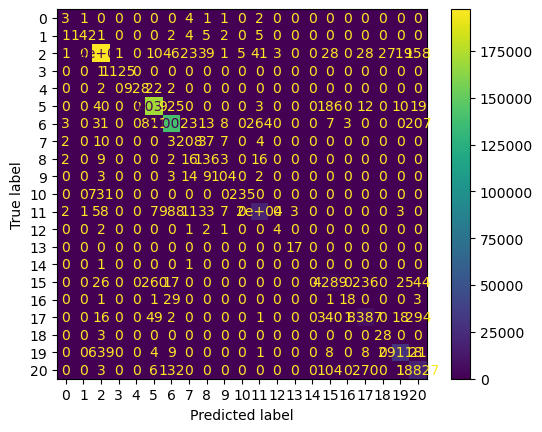

In [60]:
# 테스트 데이터에 대해 predict 수행
# 모델 성능 - confusion matrix
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

conf_mat = confusion_matrix(y_true=y_test_1, y_pred=yhat_val)
conf_mat

disp = ConfusionMatrixDisplay(conf_mat)
#disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

In [40]:
# load models from file
# for both logistic and nueral
def load_merge_models(n_models):
	all_models = list()

	for i in range(n_models):
		# define filename for this ensemble
#		colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
		#model_4.save(colab_path + 'model4.h5')
		if i != 5 and i != 4: #Model4와 Binary 배제
			filename = colab_model_write_path + 'model1_' + str(i + 1) + '.h5'
			# load model from file
			model = load_model(filename,custom_objects=None)
			# add to list of members
			all_models.append(model)
			print('>loaded %s' % filename)
	return all_models


### Merge 7

In [41]:
# load all models
#neural
from keras.models import load_model
n_members = 6
members = load_merge_models(n_members)
print('Loaded %d models' % len(members))

# define ensemble model
import matplotlib.pyplot as plt
#from keras.utils import plot_model
#neural
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

stacked_model = define_stacked_model(members)

from keras.utils import to_categorical
fit_stacked_model(stacked_model, x_train,y_train)
stacked_model.save(colab_model_write_path + 'stacked_model_3M_merge7.h5')

>loaded /home/marius1406/202310120135/model1_1.h5
>loaded /home/marius1406/202310120135/model1_2.h5
>loaded /home/marius1406/202310120135/model1_3.h5
>loaded /home/marius1406/202310120135/model1_4.h5
Loaded 4 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_2a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_3a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_4a_input (InputLa

In [42]:
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

18750/18750 - 46s - 46s/epoch - 2ms/step
Stacked Test Accuracy: 0.9852


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, yhat_val))
classification_report(y_test_1, yhat_val)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.99      0.88      0.93       162
           2       0.99      1.00      0.99    198477
           3       1.00      1.00      1.00      1126
           4       1.00      0.97      0.99       954
           5       0.99      0.99      0.99    171544
           6       0.98      0.99      0.99    141449
           7       0.54      0.81      0.65       271
           8       0.49      0.77      0.60       184
           9       0.99      0.73      0.84       135
          10       1.00      0.23      0.38       966
          11       0.99      0.94      0.96     20974
          12       0.83      0.50      0.62        10
          13       0.81      0.76      0.79        17
          14       0.00      0.00      0.00         2
          15       0.90      0.76      0.83      5374
          16       0.89      0.30      0.45        53
          17       0.92    

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        12\n           1       0.99      0.88      0.93       162\n           2       0.99      1.00      0.99    198477\n           3       1.00      1.00      1.00      1126\n           4       1.00      0.97      0.99       954\n           5       0.99      0.99      0.99    171544\n           6       0.98      0.99      0.99    141449\n           7       0.54      0.81      0.65       271\n           8       0.49      0.77      0.60       184\n           9       0.99      0.73      0.84       135\n          10       1.00      0.23      0.38       966\n          11       0.99      0.94      0.96     20974\n          12       0.83      0.50      0.62        10\n          13       0.81      0.76      0.79        17\n          14       0.00      0.00      0.00         2\n          15       0.90      0.76      0.83      5374\n          16       0.89      0.30      0.45        53\n       

18750/18750 - 34s - 34s/epoch - 2ms/step
Stacked Test Accuracy: 0.9852


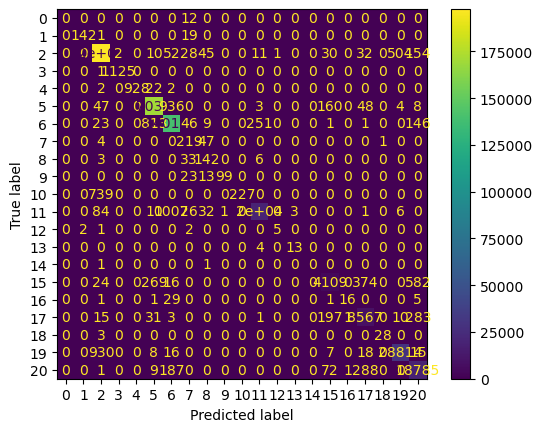

In [44]:
# 테스트 데이터에 대해 predict 수행
# 모델 성능 - confusion matrix
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

conf_mat = confusion_matrix(y_true=y_test_1, y_pred=yhat_val)
conf_mat

disp = ConfusionMatrixDisplay(conf_mat)
#disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

### BM 7

In [45]:
# load models from file
# for both logistic and nueral
def load_BM_models(n_models):
	all_models = list()

	for i in range(n_models):
		# define filename for this ensemble
#		colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
		#model_4.save(colab_path + 'model4.h5')
		if i != 5 and i != 3: #Model4와 Binary 배제
			filename = colab_model_write_path + 'model1_' + str(i + 1) + '.h5'
			# load model from file
			model = load_model(filename,custom_objects=None)
			# add to list of members
			all_models.append(model)
			print('>loaded %s' % filename)
	return all_models


In [46]:
# load all models
#neural
from keras.models import load_model
n_members = 6
members = load_BM_models(n_members)
print('Loaded %d models' % len(members))

# define ensemble model
import matplotlib.pyplot as plt
#from keras.utils import plot_model
#neural
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

stacked_model = define_stacked_model(members)

from keras.utils import to_categorical
fit_stacked_model(stacked_model, x_train,y_train)
stacked_model.save(colab_model_write_path + 'stacked_model_3M_BM7.h5')

>loaded /home/marius1406/202310120135/model1_1.h5
>loaded /home/marius1406/202310120135/model1_2.h5
>loaded /home/marius1406/202310120135/model1_3.h5
>loaded /home/marius1406/202310120135/model1_5.h5
Loaded 4 models
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_2a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_3a_input (InputLayer)    [(None, 127)]        0           []                               
                                                                                                  
 dense_1a_input (InputLa

In [47]:
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

18750/18750 - 77s - 77s/epoch - 4ms/step
Stacked Test Accuracy: 0.9853


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, yhat_val))
classification_report(y_test_1, yhat_val)

              precision    recall  f1-score   support

           0       1.00      0.08      0.15        12
           1       0.99      0.88      0.93       162
           2       0.99      0.99      0.99    198477
           3       1.00      1.00      1.00      1126
           4       1.00      0.97      0.99       954
           5       0.99      0.99      0.99    171544
           6       0.98      0.99      0.99    141449
           7       0.77      0.55      0.64       271
           8       0.52      0.53      0.53       184
           9       0.58      0.77      0.66       135
          10       0.99      0.24      0.39       966
          11       0.98      0.95      0.96     20974
          12       1.00      0.30      0.46        10
          13       0.92      0.65      0.76        17
          14       0.00      0.00      0.00         2
          15       0.90      0.77      0.83      5374
          16       0.89      0.32      0.47        53
          17       0.93    

'              precision    recall  f1-score   support\n\n           0       1.00      0.08      0.15        12\n           1       0.99      0.88      0.93       162\n           2       0.99      0.99      0.99    198477\n           3       1.00      1.00      1.00      1126\n           4       1.00      0.97      0.99       954\n           5       0.99      0.99      0.99    171544\n           6       0.98      0.99      0.99    141449\n           7       0.77      0.55      0.64       271\n           8       0.52      0.53      0.53       184\n           9       0.58      0.77      0.66       135\n          10       0.99      0.24      0.39       966\n          11       0.98      0.95      0.96     20974\n          12       1.00      0.30      0.46        10\n          13       0.92      0.65      0.76        17\n          14       0.00      0.00      0.00         2\n          15       0.90      0.77      0.83      5374\n          16       0.89      0.32      0.47        53\n       

18750/18750 - 33s - 33s/epoch - 2ms/step
Stacked Test Accuracy: 0.9853


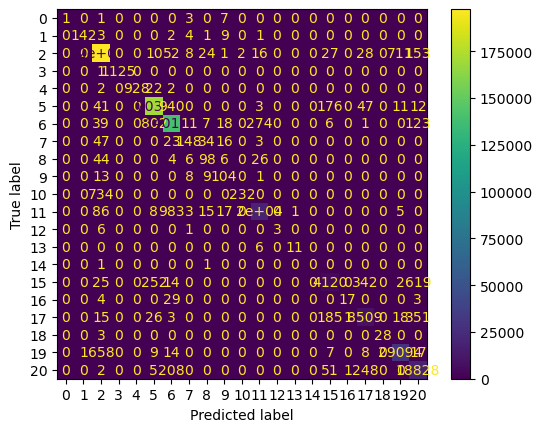

In [49]:
# 테스트 데이터에 대해 predict 수행
# 모델 성능 - confusion matrix
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

conf_mat = confusion_matrix(y_true=y_test_1, y_pred=yhat_val)
conf_mat

disp = ConfusionMatrixDisplay(conf_mat)
#disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()